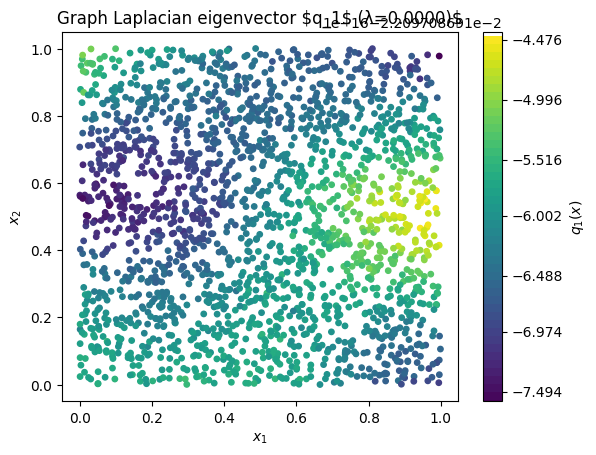

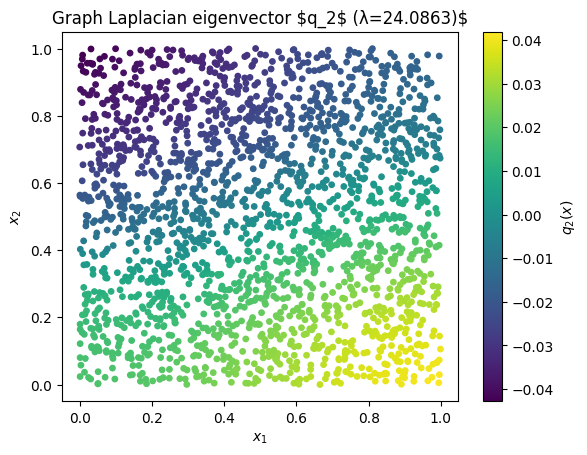

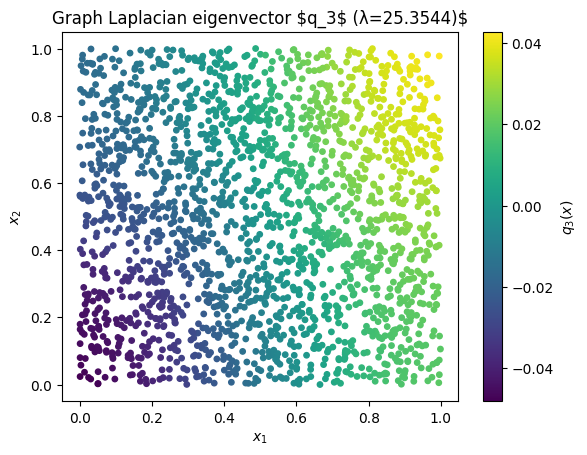

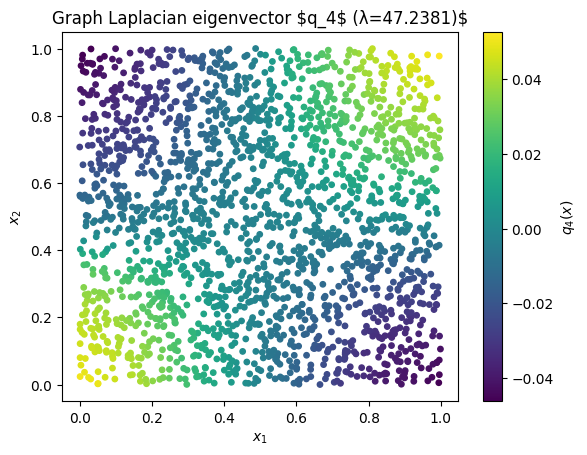

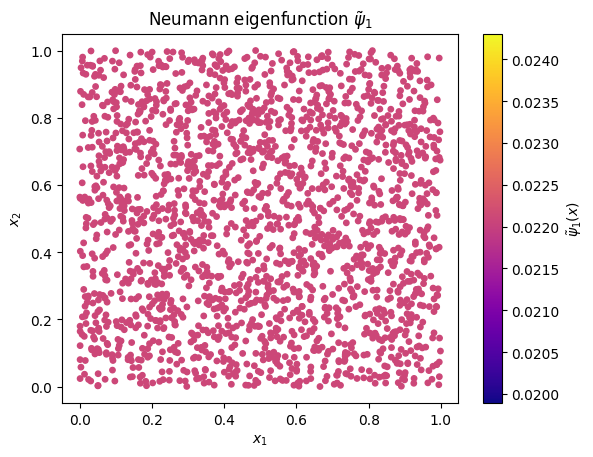

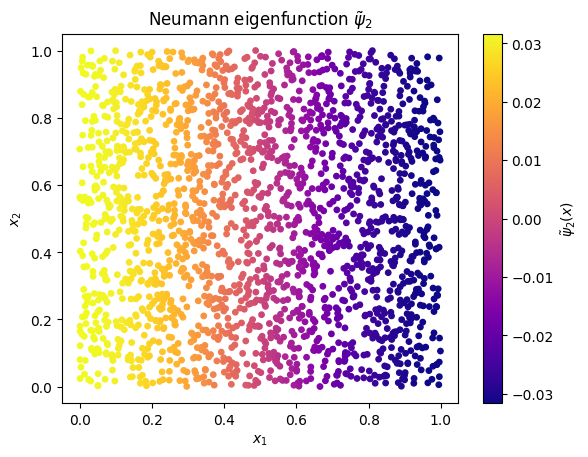

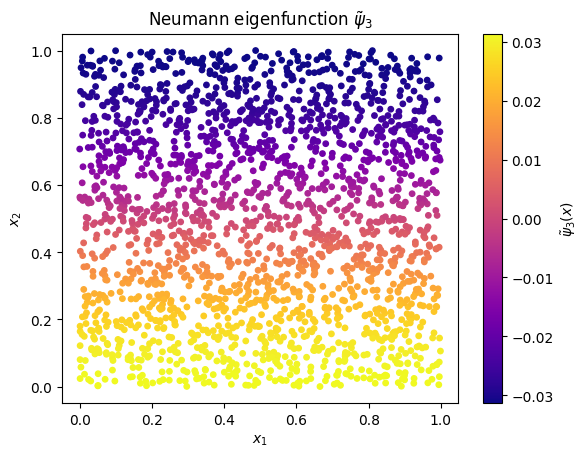

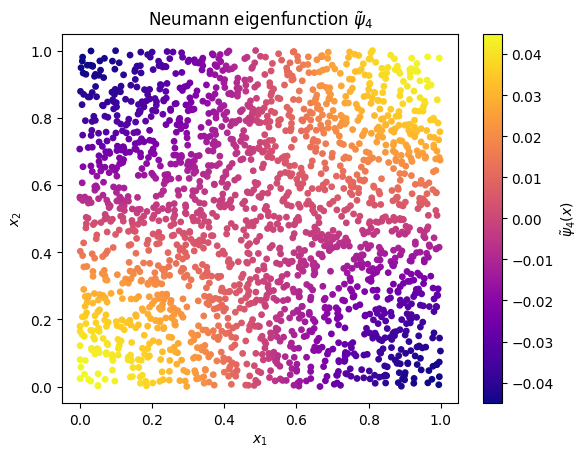

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.pyplot as plt

# ----------------------------
# Problem 1: Graph Laplacian
# ----------------------------
m = 2048
C = 1.0
ε = C * (np.log(m)**(3/4)) / np.sqrt(m)

# 1a) sample m points uniformly in [0,1]^2
X = np.random.rand(m, 2)

# 1b) build sparse weight matrix W with cutoff ε
#     W_ij = (π ε^2)^(-1) if ||x_i - x_j|| ≤ ε, else 0
W = radius_neighbors_graph(
    X, radius=ε,
    mode='connectivity',
    include_self=False,
    n_jobs=-1
).astype(float)
W *= 1.0 / (np.pi * ε**2)
W.setdiag(0)
W.eliminate_zeros()

# 1c) form degree matrix D and unnormalized Laplacian L = D - W
d = np.array(W.sum(axis=1)).ravel()
D = sp.diags(d)
L = D - W

# 1d) compute the four smallest eigenpairs of L
#     (use shift-invert or 'SM' for smallest eigenvalues)
vals, vecs = eigsh(L, k=4, which='SM')

# 1e) plot each eigenvector over the unit square
for i in range(4):
    plt.figure()
    plt.scatter(X[:,0], X[:,1],
                c=vecs[:,i], s=15,
                cmap='viridis')
    plt.colorbar(label=f'$q_{i+1}(x)$')
    plt.title(f'Graph Laplacian eigenvector $q_{i+1}$ (λ={vals[i]:.4f})$')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
plt.show()

# ----------------------------
# Problem 2: Neumann eigenfunctions
# ----------------------------

# 2a) continuous eigenfunctions on [0,1]^2 under Neumann BCs:
#     ψ_{n,k}(x) = cos(n π x1) · cos(k π x2)
# the four smallest (n,k) in increasing n^2 + k^2 are:
#    (0,0), (1,0), (0,1), (1,1)

psi = np.zeros((m, 4))
# constant mode
psi[:,0] = 1.0
# (1,0) mode
psi[:,1] = np.cos(np.pi * X[:,0])
# (0,1) mode
psi[:,2] = np.cos(np.pi * X[:,1])
# (1,1) mode
psi[:,3] = np.cos(np.pi * X[:,0]) * np.cos(np.pi * X[:,1])

# 2b) normalize each vector in ℓ²
norms = np.linalg.norm(psi, axis=0)
psi_tilde = psi / norms

# 2c) plot the four normalized modes ψ̃_j
for j in range(4):
    plt.figure()
    plt.scatter(X[:,0], X[:,1],
                c=psi_tilde[:,j], s=15,
                cmap='plasma')
    plt.colorbar(label=f'$\\tilde\\psi_{j+1}(x)$')
    plt.title(f'Neumann eigenfunction $\\tilde\\psi_{j+1}$')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
plt.show()


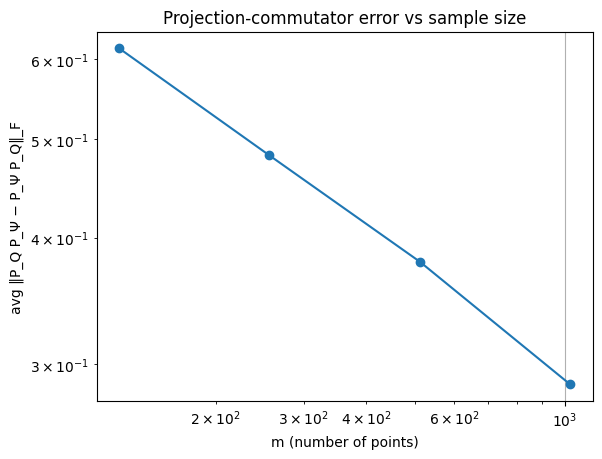

<ipython-input-5-d84660d4a7a2>:37: RuntimeWarning: invalid value encountered in divide
  psi_tilde = psi / norms


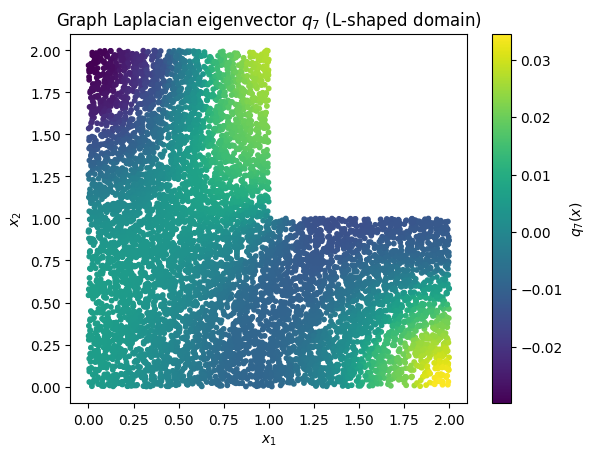

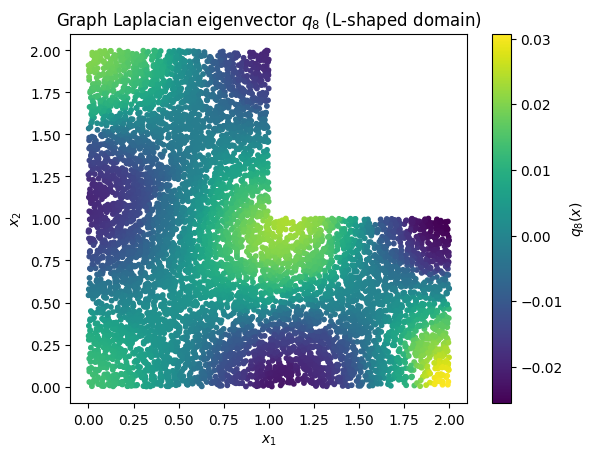

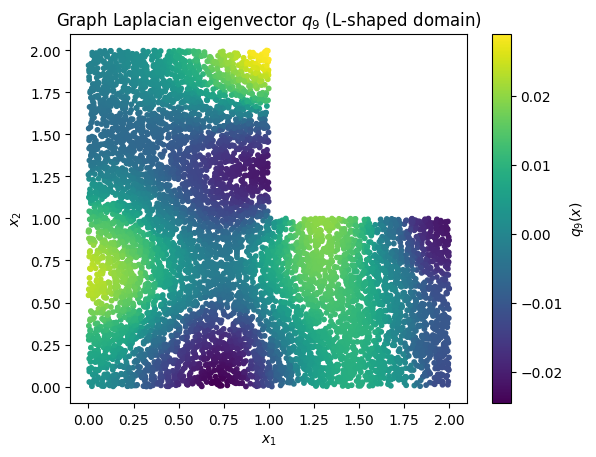

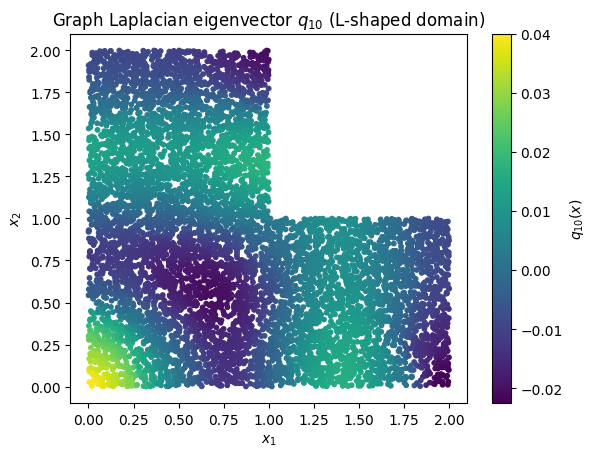

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import radius_neighbors_graph
import matplotlib.pyplot as plt

def graph_and_neumann_modes(X, C=1.0, k=4):
    """
    Given m×2 array X of points in [0,1]^2, compute:
      • the first k graph‐Laplacian eigenvectors q_j
      • the first k Neumann eigenfunctions ψ_j at X
    Returns (q, psi_tilde), each m×k.
    """
    m = X.shape[0]
    # bandwidth ε
    ε = C * (np.log(m)**(3/4)) / np.sqrt(m)
    # build W
    W = radius_neighbors_graph(X, radius=ε, mode='connectivity',
                               include_self=False, n_jobs=-1)
    W = W.astype(float) * (1.0 / (np.pi*ε**2))
    W.setdiag(0); W.eliminate_zeros()
    # Laplacian
    d = np.array(W.sum(axis=1)).ravel()
    L = sp.diags(d) - W
    # graph eigenpairs
    vals, vecs = eigsh(L, k=k, which='SM')
    q = vecs  # m×k
    # continuous Neumann modes on unit square
    psi = np.zeros((m, k))
    # ordering: (0,0),(1,0),(0,1),(1,1),…
    psi[:,0] = 1.0
    if k>1: psi[:,1] = np.cos(np.pi * X[:,0])
    if k>2: psi[:,2] = np.cos(np.pi * X[:,1])
    if k>3: psi[:,3] = np.cos(np.pi * X[:,0]) * np.cos(np.pi * X[:,1])
    # normalize in ℓ²
    norms = np.linalg.norm(psi, axis=0)
    psi_tilde = psi / norms
    return q, psi_tilde

# ---------------------------------------------------
# Part 3: projection‐commutator error vs m
# ---------------------------------------------------
ms = [2**7, 2**8, 2**9, 2**10]
trials = 30
avg_error = []

for m in ms:
    errs = []
    for _ in range(trials):
        # sample m points in [0,1]^2
        X = np.random.rand(m,2)
        # compute first 4 modes
        Q, Psi = graph_and_neumann_modes(X, C=1.0, k=4)
        # projectors P_Q, P_Psi
        P_Q   = Q   @ Q.T
        P_Psi = Psi @ Psi.T
        # commutator error
        E = P_Q @ P_Psi - P_Psi @ P_Q
        errs.append(np.linalg.norm(E, 'fro'))
    avg_error.append(np.mean(errs))

plt.figure()
plt.loglog(ms, avg_error, 'o-')
plt.xlabel('m (number of points)')
plt.ylabel('avg ‖P_Q P_Ψ − P_Ψ P_Q‖_F')
plt.title('Projection‐commutator error vs sample size')
plt.grid(True)
plt.show()

# ---------------------------------------------------
# Part 4: L‐shaped domain eigenvectors q₇…q₁₀
# ---------------------------------------------------
m = 2**13
# sample uniformly on L‐shaped region
pts = []
while len(pts) < m:
    p = 2*np.random.rand(2)  # in [0,2]^2
    # reject if in top‐right unit square
    if not (p[0]>1 and p[1]>1):
        pts.append(p)
X_L = np.array(pts)

# compute first 10 graph modes on L‐shape
q_all, _ = graph_and_neumann_modes(X_L, C=1.0, k=10)

# plot modes 7–10 (index 6–9)
for j in range(6,10):
    plt.figure()
    plt.scatter(X_L[:,0], X_L[:,1],
                c=q_all[:,j], s=10, cmap='viridis')
    plt.colorbar(label=f'$q_{{{j+1}}}(x)$')
    plt.title(f'Graph Laplacian eigenvector $q_{{{j+1}}}$ (L‐shaped domain)')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.show()


In [ ]:
# --- for the graph‐Laplacian scatter plots (q1…q4) ---
for i in range(4):
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=vecs[:,i], s=15, cmap='viridis')
    plt.colorbar(label=f'$q_{i+1}(x)$')
    plt.title(f'Graph Laplacian $q_{i+1}$ (λ={vals[i]:.4f})')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    filename = os.path.join(out_dir, f"graph_q{i+1}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# --- for the Neumann modes (ψ̃1…ψ̃4) ---
for j in range(4):
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=psi_tilde[:,j], s=15, cmap='plasma')
    plt.colorbar(label=f'$\\tilde\\psi_{j+1}(x)$')
    plt.title(f'Neumann eigenfunction $\\tilde\\psi_{j+1}$')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    filename = os.path.join(out_dir, f"neumann_psi{j+1}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
# -----------------------------
# Saving figures for Part 3
# -----------------------------
plt.figure()
plt.loglog(ms, avg_error, 'o-')
plt.xlabel('m (number of points)')
plt.ylabel(r'$\mathrm{avg}\,\|P_QP_\Psi-P_\Psi P_Q\|_F$')
plt.title('Projection–commutator error vs sample size')
plt.grid(True, which='both')
plt.savefig("figures/error_vs_m.png", dpi=300, bbox_inches='tight')
plt.close()

# -----------------------------
# Saving figures for Part 4
# -----------------------------
for j in range(6, 10):          # q₇ … q₁₀  (indices 6–9)
    plt.figure()
    plt.scatter(X_L[:, 0], X_L[:, 1],
                c=q_all[:, j], s=8, cmap='viridis')
    plt.colorbar(label=fr'$q_{{{j+1}}}(x)$')
    plt.title(fr'L–shaped domain: graph eigenvector $q_{{{j+1}}}$')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    fname = f"figures/Lshape_q{j+1}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close()


In [ ]:
!zip -r /content/figures.zip /content/figures

updating: content/figures/ (stored 0%)
updating: content/figures/Lshape_q7.png (deflated 1%)
updating: content/figures/graph_q3.png (deflated 1%)
updating: content/figures/neumann_psi1.png (deflated 3%)
updating: content/figures/error_vs_m.png (deflated 15%)
updating: content/figures/graph_q2.png (deflated 1%)
updating: content/figures/neumann_psi2.png (deflated 1%)
updating: content/figures/Lshape_q10.png (deflated 1%)
updating: content/figures/Lshape_q9.png (deflated 1%)
updating: content/figures/graph_q1.png (deflated 1%)
updating: content/figures/graph_q4.png (deflated 1%)
updating: content/figures/Lshape_q8.png (deflated 1%)
updating: content/figures/neumann_psi3.png (deflated 1%)
updating: content/figures/neumann_psi4.png (deflated 1%)
  adding: content/figures/surface_psi1.png (deflated 11%)
  adding: content/figures/Lshape_surface_q7.png (deflated 8%)
  adding: content/figures/surface_q1.png (deflated 9%)
  adding: content/figures/surface_q3.png (deflated 9%)
  adding: content/

In [ ]:
# -------------------------------------------------------------
# 3-D surface plots for a chosen eigenvector / eigenfunction
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # noqa: F401 (needed for 3-D)
from scipy.interpolate import griddata

def surface_plot(X, values, fname, title, cmap='viridis'):
    """
    X       : (m,2) array of sample points
    values  : (m,) array of f(x_i) to visualise
    fname   : where to save the PNG
    title   : plot title
    """
    # interpolate onto a 200×200 grid for smooth surface
    grid_x, grid_y = np.mgrid[0:1:200j, 0:1:200j]
    Z = griddata(X, values, (grid_x, grid_y), method='cubic')

    fig = plt.figure(figsize=(6,4.8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(grid_x, grid_y, Z,
                           cmap=cmap, linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.6, label='$f(x)$')
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.set_zlabel('$f(x)$')
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()

# ----------------------------------------------------------------
# Example: plot q2 (graph mode) and ψ̃2 (Neumann mode) for m=2048
# ----------------------------------------------------------------
surface_plot(X, vecs[:,1],
             'figures/surface_q2.png',
             'Graph Laplacian mode $q_2$')

surface_plot(X, psi_tilde[:,1],
             'figures/surface_psi2.png',
             'Neumann eigenfunction $\\tilde\\psi_2$',
             cmap='plasma')


In [ ]:
############################################################
# 0. helper -------------------------------------------------
############################################################
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D          # noqa: F401
from scipy.interpolate import griddata
import os

def surface_plot(X, values, fname, title, cmap='viridis'):
    """Interpolate scattered data to a grid and save a 3-D surface plot."""
    # make sure the output directory exists
    os.makedirs(os.path.dirname(fname), exist_ok=True)

    # cubic interpolation onto a regular 200×200 lattice
    gx, gy = np.mgrid[0:1:200j, 0:1:200j]
    Z = griddata(X, values, (gx, gy), method='cubic')

    fig = plt.figure(figsize=(6, 4.8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(gx, gy, Z,
                           cmap=cmap,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.6, label='$f(x)$')
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.set_zlabel('$f(x)$')
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()


############################################################
# 1. Problem 1 – graph modes q1 … q4 on the unit square
############################################################
# assumes:  X      – (m,2) array of points in [0,1]²
#           vecs   – (m,4) array; vecs[:,i] is q_{i+1}
for j in range(4):
    surface_plot(X,
                 vecs[:, j],
                 f'figures/surface_q{j+1}.png',
                 fr'Graph Laplacian mode $q_{{{j+1}}}$')


############################################################
# 2. Problem 2 – Neumann modes ψ̃1 … ψ̃4 on the unit square
############################################################
# assumes:  psi_tilde – (m,4) array; psi_tilde[:,i] is ψ̃_{i+1}
for j in range(4):
    surface_plot(X,
                 psi_tilde[:, j],
                 f'figures/surface_psi{j+1}.png',
                 fr'Neumann eigenfunction $\tilde{{\psi}}_{{{j+1}}}$',
                 cmap='plasma')


############################################################
# 3. Problem 4 – graph modes q7 … q10 on the L-shaped domain
############################################################
# assumes:  X_L    – (m_L,2) points in Ω_L
#           q_all  – (m_L,10) eigenvectors; q_all[:,i] is q_{i+1}
for j in range(6, 10):                    # indices 6 … 9  →  q7 … q10
    surface_plot(X_L,
                 q_all[:, j],
                 f'figures/Lshape_surface_q{j+1}.png',
                 fr'L-shape mode $q_{{{j+1}}}$')
